In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    # tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

idx = pd.IndexSlice
sns.set_style('whitegrid')

np.random.seed(42)
results_path = Path('results', 'lstm_embeddings')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [3]:
data = pd.read_hdf('rnn_data.h5', 'returns_weekly')
data['ticker'] = pd.factorize(data.index.get_level_values('ticker'))[0]
data['month'] = data.index.get_level_values('date').month
data = pd.get_dummies(data, columns=['month'], prefix='month')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1167341 entries, ('A', Timestamp('2009-01-11 00:00:00')) to ('ZUMZ', Timestamp('2017-12-31 00:00:00'))
Data columns (total 67 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fwd_returns  1167341 non-null  float64
 1   1            1167341 non-null  float64
 2   2            1167341 non-null  float64
 3   3            1167341 non-null  float64
 4   4            1167341 non-null  float64
 5   5            1167341 non-null  float64
 6   6            1167341 non-null  float64
 7   7            1167341 non-null  float64
 8   8            1167341 non-null  float64
 9   9            1167341 non-null  float64
 10  10           1167341 non-null  float64
 11  11           1167341 non-null  float64
 12  12           1167341 non-null  float64
 13  13           1167341 non-null  float64
 14  14           1167341 non-null  float64
 15  15           1167341 non-null  float64
 16  16           1167

In [4]:
data.head()

fwd_returns         1         2         3         4  \
ticker date                                                              
A      2009-01-11     0.140394  0.051133 -0.050983 -0.063830  0.007532   
       2009-01-18     0.053456  0.140394  0.051133 -0.050983 -0.063830   
       2009-01-25    -0.044593  0.053456  0.140394  0.051133 -0.050983   
       2009-02-01    -0.030043 -0.044593  0.053456  0.140394  0.051133   
       2009-02-08     0.067478 -0.030043 -0.044593  0.053456  0.140394   

                          5         6         7         8         9  ...  \
ticker date                                                          ...   
A      2009-01-11 -0.083378  0.089069 -0.163861 -0.049908 -0.015773  ...   
       2009-01-18  0.007532 -0.083378  0.089069 -0.166667 -0.049908  ...   
       2009-01-25 -0.063830  0.007532 -0.083378  0.089069 -0.166747  ...   
       2009-02-01 -0.050983 -0.063830  0.007532 -0.083378  0.089069  ...   
       2009-02-08  0.051133 -0.050983 -0.063830  0.007532 -0.083378  ...   

                   month_3  month_4  month_5  month_6  month_7  month_8  \
ticker date                                                               
A      2009-01-11        0        0        0        0        0        0   
       2009-01-18        0        0        0        0        0        0   
       2009-01-25        0        0        0        0        0        0   
       2009-02-01        0        0        0        0        0        0   
       2009-02-08        0        0        0        0        0        0   

                   month_9  month_10  month_11  month_12  
ticker date                                               
A      2009-01-11        0         0         0         0  
       2009-01-18        0         0         0         0  
       2009-01-25        0         0         0         0  
       2009-02-01        0         0         0         0  
       2009-02-08        0         0         0         0  

[5 rows x 67 columns]

In [5]:
# Train-test split
window_size=52
sequence = list(range(1, window_size+1))
ticker = 1
months = 12
n_tickers = data.ticker.nunique()
train_data = data.drop('fwd_returns', axis=1).loc[idx[:, :'2016'], :]
test_data = data.drop('fwd_returns', axis=1).loc[idx[:, '2017'],:]

In [6]:
# reshape to 3 dimensions for RNN
X_train = [
            train_data.loc[:, sequence].values.reshape(-1, window_size , 1), # lagged return series
            train_data.ticker, # integer encoded stock ticker (1 dimensional array)
            train_data.filter(like='month') # month dummies as a 2 dimensional array with 1 column per month
          ]
# label(fwd_returns) > 0 ==> 1 otherwise 0 (by RNN_BuildDataset) for binary price changes
y_train = train_data.label
[x.shape for x in X_train], y_train.shape

([(1035424, 52, 1), (1035424,), (1035424, 12)], (1035424,))

In [7]:
train_data.filter(like='month')

month_1  month_2  month_3  month_4  month_5  month_6  \
ticker date                                                               
A      2009-01-11        1        0        0        0        0        0   
       2009-01-18        1        0        0        0        0        0   
       2009-01-25        1        0        0        0        0        0   
       2009-02-01        0        1        0        0        0        0   
       2009-02-08        0        1        0        0        0        0   
...                    ...      ...      ...      ...      ...      ...   
ZUMZ   2016-11-27        0        0        0        0        0        0   
       2016-12-04        0        0        0        0        0        0   
       2016-12-11        0        0        0        0        0        0   
       2016-12-18        0        0        0        0        0        0   
       2016-12-25        0        0        0        0        0        0   

                   month_7  month_8  month_9  month_10  month_11  month_12  
ticker date                                                                 
A      2009-01-11        0        0        0         0         0         0  
       2009-01-18        0        0        0         0         0         0  
       2009-01-25        0        0        0         0         0         0  
       2009-02-01        0        0        0         0         0         0  
       2009-02-08        0        0        0         0         0         0  
...                    ...      ...      ...       ...       ...       ...  
ZUMZ   2016-11-27        0        0        0         0         1         0  
       2016-12-04        0        0        0         0         0         1  
       2016-12-11        0        0        0         0         0         1  
       2016-12-18        0        0        0         0         0         1  
       2016-12-25        0        0        0         0         0         1  

[1035424 rows x 12 columns]

In [6]:
# keep the last year for testing
X_test = [test_data.loc[:, list(range(1, window_size+1))].values.reshape(-1, window_size , 1),
    test_data.ticker, test_data.filter(like='month')]
y_test = test_data.label
[x.shape for x in X_test], y_test.shape

([(131917, 52, 1), (131917,), (131917, 12)], (131917,))

In [8]:
# Define the Model Architecture
K.clear_session()
n_features = 1
returns = Input(shape=(window_size, n_features), name='Returns')
tickers = Input(shape=(1,), name='Tickers')
months = Input(shape=(12,), name='Months')

# LSTM Layers
lstm1_units = 25
lstm2_units = 10
lstm1 = LSTM(units=lstm1_units, input_shape=(window_size, n_features), name='LSTM1', dropout=.2,
             return_sequences=True)(returns)

lstm_model = LSTM(units=lstm2_units, dropout=.2, name='LSTM2')(lstm1)

In [9]:
# Embedding Layer
ticker_embedding = Embedding(input_dim=n_tickers, output_dim=5, input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(5,))(ticker_embedding)

In [10]:
# Concatenate Model components
merged = concatenate([lstm_model, ticker_embedding, months], name='Merged')

bn = BatchNormalization()(merged)
hidden_dense = Dense(10, name='FC1')(bn)

output = Dense(1, name='Output', activation='sigmoid')(hidden_dense)

rnn = Model(inputs=[returns, tickers, months], outputs=output)

In [11]:
rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Returns (InputLayer)           [(None, 52, 1)]      0           []                               
                                                                                                  
 Tickers (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 LSTM1 (LSTM)                   (None, 52, 25)       2700        ['Returns[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         12445       ['Tickers[0][0]']                
                                                                                              

In [12]:
# Train the Model
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
rnn.compile(loss='binary_crossentropy', optimizer=optimizer,
            metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')])
lstm_path = (results_path / 'lstm.classification.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path, verbose=1, monitor='val_AUC', mode='max',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_AUC', patience=5, restore_best_weights=True, mode='max')
training = rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                   callbacks=[early_stopping, checkpointer], verbose=1, workers=6)

Epoch 1/50
32353/32357 [============================>.] - ETA: 0s - loss: 0.6895 - accuracy: 0.5365 - AUC: 0.5493
Epoch 00001: val_AUC improved from -inf to 0.62010, saving model to results/lstm_embeddings\lstm.classification.h5
32357/32357 [==============================] - 386s 12ms/step - loss: 0.6895 - accuracy: 0.5365 - AUC: 0.5493 - val_loss: 0.6783 - val_accuracy: 0.5754 - val_AUC: 0.6201
Epoch 2/50
32355/32357 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5475 - AUC: 0.5655
Epoch 00002: val_AUC improved from 0.62010 to 0.62713, saving model to results/lstm_embeddings\lstm.classification.h5
32357/32357 [==============================] - 372s 11ms/step - loss: 0.6861 - accuracy: 0.5475 - AUC: 0.5655 - val_loss: 0.6780 - val_accuracy: 0.5723 - val_AUC: 0.6271
Epoch 3/50
32353/32357 [============================>.] - ETA: 0s - loss: 0.6811 - accuracy: 0.5485 - AUC: 0.5683
Epoch 00003: val_AUC improved from 0.62713 to 0.67151, saving model to results/lstm_e

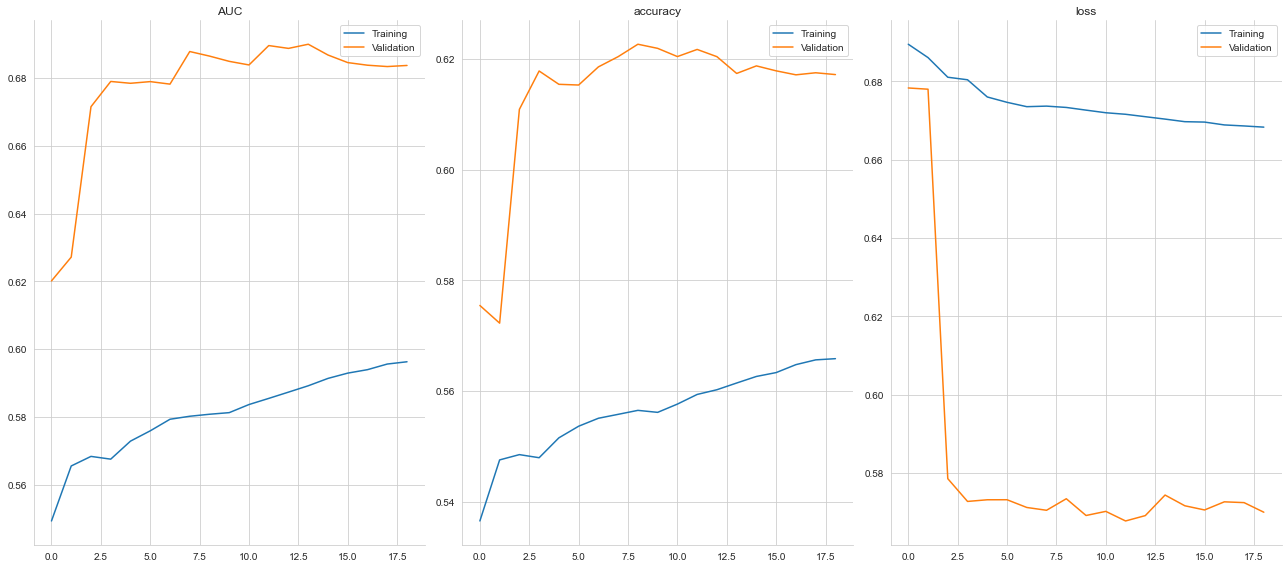

In [13]:
loss_history = pd.DataFrame(training.history)
def which_metric(m):
    return m.split('_')[-1]
fig, axes = plt.subplots(ncols=3, figsize=(18,8))

for i, (metric, hist) in enumerate(loss_history.groupby(which_metric, axis=1)):
    hist.plot(ax=axes[i], title=metric)
    axes[i].legend(['Training', 'Validation'])

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_stacked_classification', dpi=300);

In [14]:
# Evaluate model(directional price moves estimation) performance
test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)
roc_auc_score(y_score=test_predict, y_true=y_test)

0.6899879139445898

In [15]:
((test_predict>.5) == y_test).astype(int).mean()

0.6173578841241083

In [16]:
spearmanr(test_predict, y_test)[0]

0.32505728563581054